# SF Crime Data Model Iteration 1
### Keenan and Joe


## Abstract:

For this project on the San Francisco Crime data, we are given the location and time of a crime, and we must predict the catagory of the crime. There is around 20 years of data, which fortunetely is all complete! 

In this notebook, we tried using three main models, a Naive Bayes model, a Logistic Regression model, and a Stochasitc Gradient Descent model. They all returned relatively simliar scores, but the best one by an edge was the Naive Bayes model. 

### Part 1, Grab All of the Data!

We imported a bunch of necessary packages and read the data.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import numpy as np
 
%matplotlib inline

#Load Data with pandas, and parse the first column into datetime
train=pd.read_csv('train.csv', parse_dates = ['Dates'])
test=pd.read_csv('test.csv', parse_dates = ['Dates'])

# Keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
train = train[np.abs(train.X-train.X.mean())<=(3*train.X.std())] 
train = train[np.abs(train.Y-train.Y.mean())<=(3*train.Y.std())] 

train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


After submitting my first two submissions, I remembered from my data exploration that there were some outliers in the x and y coordinates. I added the two lines that remove points that are not within 3 standard deviations of the mean of the data.

### Part 2: Process the Data
After accumulating all of the data, we begin to do some processing. The biggest challenge facing this dataset is that many of the catagories of data are not numerical, but do not have clear scales between them. Instead of just turning them into numbers, like monday 1, tuesday 2, etc, it makes more sense to binarize the data so they have the same scale. Pandas has a great function called get_dummies which does exactly that!

In [22]:
#Convert crime labels to numbers
le_crime = preprocessing.LabelEncoder()
crime = le_crime.fit_transform(train.Category)
 
#Get binarized weekdays, districts, and hours.
days = pd.get_dummies(train.DayOfWeek)
district = pd.get_dummies(train.PdDistrict)
hour = train.Dates.dt.hour
hour = pd.get_dummies(hour) 
 
#Build new array
train_data = pd.concat([hour, days, district], axis=1)
train_data['crime']=crime
 
#Repeat for test data
days = pd.get_dummies(test.DayOfWeek)
district = pd.get_dummies(test.PdDistrict)
 
hour = test.Dates.dt.hour
hour = pd.get_dummies(hour) 
 
test_data = pd.concat([hour, days, district], axis=1)
 
training, validation = train_test_split(train_data, train_size=.60)

train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,crime
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,37
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,21
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,21
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,16
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,16


### Part 3: Time to Train a Model!

After doing this for both the test and train data, we can begin to test out our data. I used a Logistic Regression after splitting the training data to have validation set to work with as well. 

In [23]:
features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION',
 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN']


# Add in hours of the day into the features
features2 = [x for x in range(0,24)]
features = features + features2

# Use the Naive Bayes model
training, validation = train_test_split(train_data, train_size=.60)
model = BernoulliNB()
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
print "Naive Bayes: " , log_loss(validation['crime'], predicted) 
 
    
    
#Logistic Regression for comparison
model = LogisticRegression(C=.01)
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
print "Logistic Regression: " , log_loss(validation['crime'], predicted) 

Naive Bayes:  2.58183194226
Logistic Regression:  2.59129874457


### Results:

Both of these results look pretty good, but as shown, the Naive Bayes model using the BernoulliNB model, the score was slightly better, as 2.58 is lower than 2.59, and the lower the score the better in this particular model. 



In [24]:
model = BernoulliNB()
model.fit(train_data[features], train_data['crime'])
predicted = model.predict_proba(test_data[features])
 
#Write results
result=pd.DataFrame(predicted, columns=le_crime.classes_)
result.to_csv('testResult3.csv', index = True, index_label = 'Id' )


### Submit to Kaggle

I submitted this to kaggle and got a result of 2.58376, which was good enough for about 530th place out of 1250! 

### Submit to Kaggle without Outliers

After I removed the outliers from the training dataset, as mentioned above, I resubmitted to Kaggle and returned the score of: 

I learned a lot of these strategies through the tutorial at http://efavdb.com/predicting-san-francisco-crimes/

### New strategy --> SGDClassifier!

I'm going to now try a new strategy. This is called stochastic gradient descent, which means the gradient of each loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate. How it exactly works, I have no idea, but I found it on sklearn as a good model to try, so here it goes!

In [10]:
from sklearn.linear_model import SGDClassifier


sgd = SGDClassifier(loss='log', penalty='l2')
sgd.fit(training[features], training['crime'])
predicted = np.array(sgd.predict_proba(validation[features]))
sgd_log_loss = log_loss(validation['crime'], predicted) 

print sgd_log_loss

2.58323102569


That's a pretty great result! Time to make another submission to kaggle! 

In [11]:
model = SGDClassifier(loss='log', penalty='l2')
model.fit(train_data[features], train_data['crime'])
predicted = model.predict_proba(test_data[features])

result=pd.DataFrame(predicted, columns=le_crime.classes_)
result.to_csv('testResult2.csv', index = True, index_label = 'Id' )


### Results

This model achieved a score of: 2.58433, which was slightly worse than my previous score of 2.58376. But overall, the scores are pretty similar.  

# Things to add:

- Include year as a feature
- Overlay some data on a map (#data visualization)
- Combine notebooks to create the narrative
- Try or iterate over different parameters into each model
- Combine models

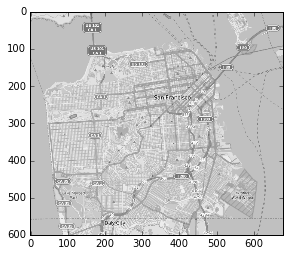

In [20]:
mapdata = np.loadtxt("./sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))
plt.show()


# OOH! LOOK AT THE PRETTY MAP OF SAN FRANCISCO! NOICE!